In [1]:
import os, sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = Path.cwd().parent
sys.path.append(str(ROOT))

from src.utils import get_project_paths
from src.clustering import scale_features, kmeans_elbow, kmeans_silhouette, fit_kmeans, characterise_segments

sns.set(style="whitegrid")

paths = get_project_paths(ROOT)
df = pd.read_parquet(paths.data_processed / "churn_ready.parquet")

df.head()


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,...,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,tenure_months,avg_orders_per_month,avg_order_value,clv_proxy,TenureBin,OrderCountBin
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,...,1.0,1.0,5.0,159.93,4.0,0.25,159.93,159.93,0-6,0-5
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,...,0.0,1.0,0.0,120.90,NaN,NaN,120.90,120.90,NaN,0-5
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,...,0.0,1.0,3.0,120.28,NaN,NaN,120.28,120.28,NaN,0-5
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,...,0.0,1.0,3.0,134.07,0.0,1.00,134.07,134.07,0-6,0-5
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,...,1.0,1.0,3.0,129.60,0.0,1.00,129.60,129.60,0-6,0-5


In [2]:
rfm_cols = [
    "CustomerID",
    "DaySinceLastOrder",
    "OrderCount",
    "CashbackAmount",
    "clv_proxy",
    "Churn",
]

rfm_df = df[rfm_cols].copy()

rfm_df.rename(
    columns={
        "DaySinceLastOrder": "recency_days",
        "OrderCount": "frequency",
        "CashbackAmount": "monetary",
    },
    inplace=True,
)

rfm_features = rfm_df[["recency_days", "frequency", "monetary", "clv_proxy"]]
rfm_features.head()


,recency_days,frequency,monetary,clv_proxy
0,5.0,1.0,159.93,159.93
1,0.0,1.0,120.90,120.90
2,3.0,1.0,120.28,120.28
3,3.0,1.0,134.07,134.07
4,3.0,1.0,129.60,129.60


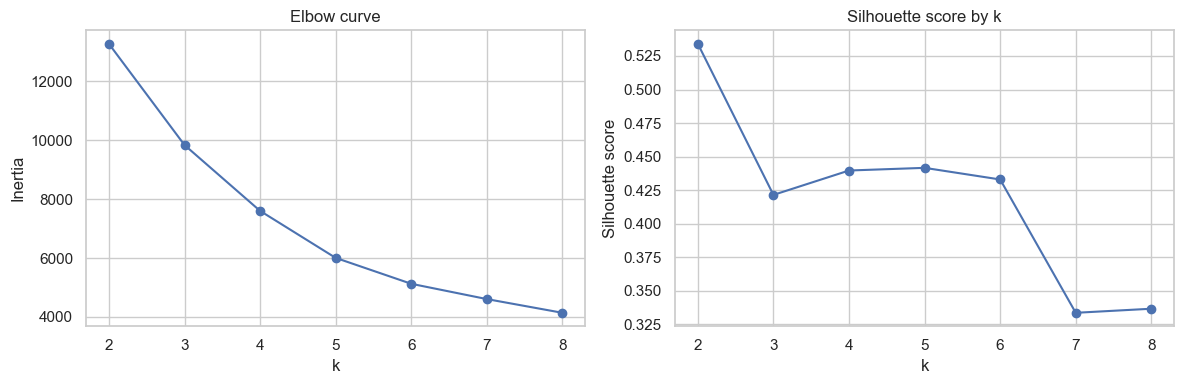

In [3]:
# Impute NaNs in RFM features
rfm_features_clean = rfm_features.copy()

rfm_features_clean = rfm_features_clean.replace([np.inf, -np.inf], np.nan)

rfm_features_clean = rfm_features_clean.fillna(rfm_features_clean.median(numeric_only=True))

rfm_scaled, rfm_scaler = scale_features(rfm_features_clean)

elbow = kmeans_elbow(rfm_scaled, k_range=range(2, 9))
sil = kmeans_silhouette(rfm_scaled, k_range=range(2, 9))


fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(list(elbow.keys()), list(elbow.values()), marker="o")
ax[0].set_xlabel("k")
ax[0].set_ylabel("Inertia")
ax[0].set_title("Elbow curve")

ax[1].plot(list(sil.keys()), list(sil.values()), marker="o")
ax[1].set_xlabel("k")
ax[1].set_ylabel("Silhouette score")
ax[1].set_title("Silhouette score by k")

plt.tight_layout()
plt.show()



In [4]:
optimal_k = 4 #based on the plots above

km, labels = fit_kmeans(rfm_scaled, n_clusters=optimal_k, random_state=42)
rfm_df["segment"] = labels

rfm_df["segment"].value_counts().sort_index()


segment
0    3395
1    1174
2     247
3     814
Name: count, dtype: int64

In [5]:
segment_summary = characterise_segments(
    df=rfm_df,
    cluster_col="segment",
    agg_cols=["recency_days", "frequency", "monetary", "clv_proxy"],
)

segment_summary["churn_rate"] = (
    rfm_df.groupby("segment")["Churn"].mean().values
)

segment_summary.sort_values("clv_proxy", ascending=False)


,segment,recency_days,frequency,monetary,clv_proxy,count,churn_rate
2,2,9.470588,12.133603,266.594251,3207.462834,247,0.121457
3,3,8.302356,6.676904,171.442211,1145.250467,814,0.147420
1,1,6.643750,2.209607,237.971141,533.439083,1174,0.085179
0,0,2.807658,1.679823,151.100088,257.342907,3395,0.205596


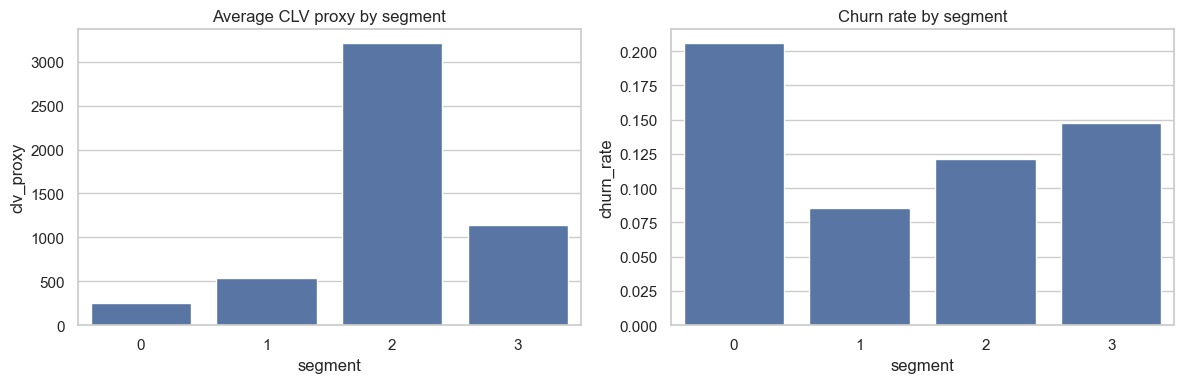

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.barplot(
    data=segment_summary,
    x="segment",
    y="clv_proxy",
    ax=axes[0]
)
axes[0].set_title("Average CLV proxy by segment")

sns.barplot(
    data=segment_summary,
    x="segment",
    y="churn_rate",
    ax=axes[1]
)
axes[1].set_title("Churn rate by segment")

plt.tight_layout()
plt.show()


In [7]:
df = df.merge(
    rfm_df[["CustomerID", "segment"]],
    on="CustomerID",
    how="left",
)

save_path = paths.data_processed / "churn_with_segments.parquet"
df.to_parquet(save_path, index=False)
save_path


PosixPath('/Users/arnavthakur/Documents/Data Science Projects/customer-analytics-churn-segmentation/data/processed/churn_with_segments.parquet')